Differences compared to NeurIPS version:

 - Dataset only has inhibitory cells now
 - E dataset has new features
 - sPC loadings are scaled differently
 - QDA is performed independently for each cut (instead of pooling probabilities)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
def get_merged_ordered_classes(data_labels,n_required_classes=30):
    """
    Exits when number of labels in the data matches or is just 
    above the required number of classes.
    
    returns:
    
    """
    from analysis_tree_helpers import HTree, do_merges

    #Load inhibitory subtree
    htree = HTree(htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
    subtree = htree.get_subtree(node='n59')
    L = subtree.get_mergeseq()
    
    #Init:
    n_remain_classes = np.unique(data_labels).size
    n = 0
    
    while n_remain_classes>n_required_classes:
        n = n+1
        merged_sample_labels = do_merges(labels=data_labels.copy(), list_changes=L, n_merges=n, verbose=False)
        n_remain_classes = np.unique(merged_sample_labels).size
        
    if n_remain_classes!=n_required_classes:
        #print('WARNING: Merges for required number of classes not found. Returning a higher number of classes')
        n = n-1
        
    new_data_labels = do_merges(labels=data_labels, list_changes=L, n_merges=n, verbose=False)
    #print('Performed {:d} merges. Remaining classes in data = {:d}'.format(n,np.unique(new_data_labels).size))
    assert np.all(np.isin(np.unique(new_data_labels),subtree.child)), "Merged labels are not listed as children in tree"

    ind = np.isin(subtree.child,np.unique(new_data_labels))
    remain_class_names = subtree.child[ind]
    remain_class_x = subtree.x[ind]
    remain_class_names = sorted(list(set(zip(remain_class_names,remain_class_x))),key=lambda x:x[1])
    class_order = [n[0] for n in remain_class_names]
    return new_data_labels,class_order

In [3]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

load all cv sets took 10.631sec


In [4]:
n_min_samples = 6
qda = QDA(reg_param=1e-2,store_covariance=True)

for cv in CVdict.keys():
    D = CVdict[cv]
    CVdict[cv]['qda'] = {}
    CVdict[cv]['qda']['n_components'] = []
    CVdict[cv]['qda']['n_htree_classes'] = []
    CVdict[cv]['qda']['acc_val'] = []
    CVdict[cv]['qda']['acc_test'] = []
    
    for n_classes in np.arange(5,61,5):
        
        merged_labels, _ = get_merged_ordered_classes(deepcopy(O['cluster']),n_required_classes=n_classes)
        
        X_train = deepcopy(D['zT'][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D['zT'][D['val_ind']])
        y_val = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D['zT'][D['test_ind']])
        y_test = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        #df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        #print(df_train_del['lbl'].value_counts())

        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        qda.fit(X_train,y_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        CVdict[cv]['qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
        CVdict[cv]['qda']['acc_test'].append(accuracy_score(y_test, y_test_pred))

In [5]:
test_acc = []
val_acc = []
n_components = []
for cv in CVdict.keys():
    test_acc.extend(CVdict[cv]['qda']['acc_test'])
    val_acc.extend(CVdict[cv]['qda']['acc_val'])
    n_components.extend(CVdict[cv]['qda']['n_components'])

Text(0, 0.5, 'Accuracy')

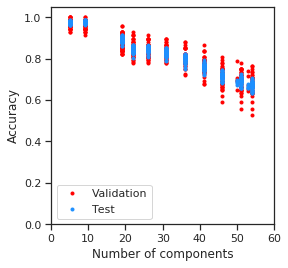

In [6]:
plt.figure(figsize=(4,4))
plt.plot(n_components,val_acc,'.',color='red',label='Validation')
plt.plot(n_components,test_acc,'.',color='dodgerblue',label='Test')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [ ]:
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc})
df.to_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_zT_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')

**PC-CCA baselines**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [4]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm

In [5]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

load all cv sets took 10.190sec


In [6]:
n_min_samples = 6
qda = QDA(reg_param=1e-2,store_covariance=True)

n_pc_T = 50
n_pc_E = 50
cca_dims = 3
fiton = 'zE'
cca = CCA(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)

In [ ]:
for cv in CVdict.keys():
    D = deepcopy(CVdict[cv])
    CVdict[cv]['pc_cca_qda'] = {}
    CVdict[cv]['pc_cca_qda']['n_components'] = []
    CVdict[cv]['pc_cca_qda']['n_htree_classes'] = []
    CVdict[cv]['pc_cca_qda']['acc_val'] = []
    CVdict[cv]['pc_cca_qda']['acc_test'] = []
    
    XT = deepcopy(O['T_dat'])
    XE = deepcopy(np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1))
    XE[np.isnan(XE)]=0.0
    train_ind = D['train_ind']
    
    #Reduce dims of T data
    if n_pc_T is not None:
        pca = PCA(n_components=n_pc_T)
        pca.fit_transform(XT[train_ind,:])
        XT = pca.transform(XT)
  
    #Reduce dims of E data
    if n_pc_E is not None:
        pca = PCA(n_components=n_pc_E)
        pca.fit_transform(XE[train_ind,:])
        XE = pca.transform(XE)

    #CCA on T and E data
    cca.fit(XT[train_ind,:],XE[train_ind,:])
    D['zT'],D['zE'] = cca.transform(XT,XE)
    
    D['zT'] = D['zT'] - np.mean(D['zT'], axis=0)
    D['zT'] = np.matmul(D['zT'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zT'])))))
    
    D['zE'] = D['zE'] - np.mean(D['zE'], axis=0)
    D['zE'] = np.matmul(D['zE'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zE'])))))

    for n_classes in np.arange(5,61,5):

        merged_labels, _ = get_merged_ordered_classes(deepcopy(O['cluster']),n_required_classes=n_classes)
        
        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D[fiton][D['test_ind']])
        y_test = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        #df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        #print(df_train_del['lbl'].value_counts())

        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        qda.fit(X_train,y_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        CVdict[cv]['pc_cca_qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['pc_cca_qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['pc_cca_qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
        CVdict[cv]['pc_cca_qda']['acc_test'].append(accuracy_score(y_test, y_test_pred))

In [ ]:
test_acc = []
val_acc = []
n_components = []
for cv in CVdict.keys():
    test_acc.extend(CVdict[cv]['pc_cca_qda']['acc_test'])
    val_acc.extend(CVdict[cv]['pc_cca_qda']['acc_val'])
    n_components.extend(CVdict[cv]['pc_cca_qda']['n_components'])

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(n_components,val_acc,'.',color='red',label='Validation')
plt.plot(n_components,test_acc,'.',color='dodgerblue',label='Test')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [ ]:
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc})
df.to_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_50-50-pc_3-cca_zE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')

**Plot stored results**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from copy import deepcopy

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
A = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_zT_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
B = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_10-10-pc_3-cca_zT_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
C = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_20-20-pc_3-cca_zT_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_50-50-pc_3-cca_zT_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')

Text(0.5, 1.0, 'QDA: t-type labels from zT')

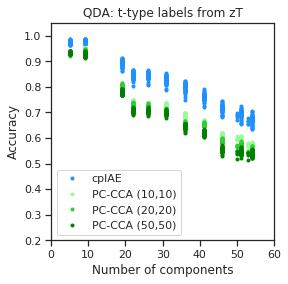

In [3]:
plt.figure(figsize=(4,4))
plt.plot(A['n_components'],A['test_acc'],'.',color='dodgerblue',label='cplAE')
plt.plot(B['n_components'],B['test_acc'],'.',color='palegreen',label='PC-CCA (10,10)')
plt.plot(C['n_components'],C['test_acc'],'.',color='limegreen',label='PC-CCA (20,20)')
plt.plot(D['n_components'],D['test_acc'],'.',color='green',label='PC-CCA (50,50)')
plt.legend()
ax = plt.gca()
ax.set_ylim(0.2,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')
ax.set_title('QDA: t-type labels from zT')

In [4]:
A = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_zE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
B = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_10-10-pc_3-cca_zE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
C = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_20-20-pc_3-cca_zE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/QDA_50-50-pc_3-cca_zE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')

Text(0.5, 1.0, 'QDA: t-type labels from zE')

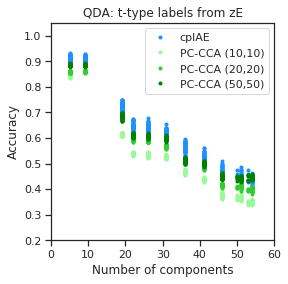

In [5]:
plt.figure(figsize=(4,4))
plt.plot(A['n_components'],A['test_acc'],'.',color='dodgerblue',label='cplAE')
plt.plot(B['n_components'],B['test_acc'],'.',color='palegreen',label='PC-CCA (10,10)')
plt.plot(C['n_components'],C['test_acc'],'.',color='limegreen',label='PC-CCA (20,20)')
plt.plot(D['n_components'],D['test_acc'],'.',color='green',label='PC-CCA (50,50)')
plt.legend()
ax = plt.gca()
ax.set_ylim(0.2,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')
ax.set_title('QDA: t-type labels from zE')

In [153]:
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
from sklearn.metrics import r2_score as r2

In [154]:
from sklearn.cross_decomposition import CCA
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES

class CCA_extended(CCA):
  
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        return
      
    def inverse_transform_xy(self,X,Y):
        """
        This module calculates the inverse transform for both X and Y
        CCA.inverse_transform module only calculates reconstructions for X
        """
        check_is_fitted(self)
        X = check_array(X, dtype=FLOAT_DTYPES)
        Y = check_array(Y, dtype=FLOAT_DTYPES)
        
        x = np.matmul(X, cca.x_loadings_.T)
        x *= cca.x_std_
        x += cca.x_mean_
        
        y = np.matmul(Y, cca.y_loadings_.T)
        y *= cca.y_std_
        y += cca.y_mean_
        return x,y

In [155]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['XrT','XrE_from_XT','XrT_from_XE','XrE','zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

load all cv sets took 9.709sec


In [156]:
n_min_samples = 6
n_pc_T = 50
n_pc_E = 50
cca_dims = 3
cca = CCA_extended(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)

In [157]:
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
XE_orig[np.isnan(XE_orig)]=0.0

for cv in CVdict.keys():
    
    CVdict[cv]['ae'] = {}
    CVdict[cv]['cca'] = {}
    
    D = deepcopy(CVdict[cv])
    XT = deepcopy(XT_orig)
    XE = deepcopy(XE_orig)
    train_ind = D['train_ind']

    #Reduce dims of T data
    pcaT = PCA(n_components=n_pc_T)
    pcaT.fit_transform(XT[train_ind,:])
    XTpc = pcaT.transform(XT)

    #Reduce dims of E data
    pcaE = PCA(n_components=n_pc_E)
    pcaE.fit_transform(XE[train_ind,:])
    XEpc = pcaE.transform(XE)

    #CCA on T and E data
    cca.fit(XTpc,XEpc)
    XTcca,XEcca = cca.transform(XTpc,XEpc)
        
    #Reconstruction frmo CCA co-ordinates----------------------------
    #Within modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XTcca,XEcca)
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = (XE_orig - XrE)**2
    
    for s in ['val','test']:
        CVdict[cv]['cca']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XT_R2'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_R2'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
    
    #Cross modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XEcca,XTcca) #Input order to inverse_transform_xy is flipped
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = (XE_orig - XrE)**2
    
    for s in ['val','test']:
        CVdict[cv]['cca']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XE_R2'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_R2'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
        
        
    #Within Modality AE
    T_se = (XT_orig - D['XrT'])**2
    E_se = (XE_orig - D['XrE'])**2
    for s in ['val','test']:
        CVdict[cv]['ae']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XT_R2'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_R2'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE'][D[s+'_ind'],:])
        

    T_se = (XT_orig - D['XrT_from_XE'])**2
    E_se = (XE_orig - D['XrE_from_XT'])**2
    for s in ['val','test']:
        CVdict[cv]['ae']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XE_R2'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT_from_XE'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_R2'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE_from_XT'][D[s+'_ind'],:])


In [61]:
L={}
L['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    L['cv'].append(cv)
    for k in CVdict[cv]['cca'].keys():
        if i == 0:
            L[k]=[]
        L[k].append(CVdict[cv]['cca'][k])

M={}
M['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    M['cv'].append(cv)
    for k in CVdict[cv]['ae'].keys():
        if i == 0:
            M[k]=[]
        M[k].append(CVdict[cv]['ae'][k])

In [62]:
df_cca = pd.DataFrame(L)
df_cca.to_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_{}-{}-pc_3-cca_Edat_pcipfx.csv'.format(n_pc_T,n_pc_T))

df_ae = pd.DataFrame(M)
df_ae.to_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_AE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')

In [66]:
A.columns

Index(['Unnamed: 0', 'cv', 'XT_from_XT_val', 'XE_from_XE_val',
       'XT_from_XT_R2val', 'XE_from_XE_R2val', 'XT_from_XT_test',
       'XE_from_XE_test', 'XT_from_XT_R2test', 'XE_from_XE_R2test',
       'XT_from_XE_val', 'XE_from_XT_val', 'XT_from_XE_R2val',
       'XE_from_XT_R2val', 'XT_from_XE_test', 'XE_from_XT_test',
       'XT_from_XE_R2test', 'XE_from_XT_R2test'],
      dtype='object')

In [64]:
A = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_AE_v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_ft_0500.csv')
B = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_10-10-pc_3-cca_Edat_pcipfx.csv')
C = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_20-20-pc_3-cca_Edat_pcipfx.csv')
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/Recon_50-50-pc_3-cca_Edat_pcipfx.csv')

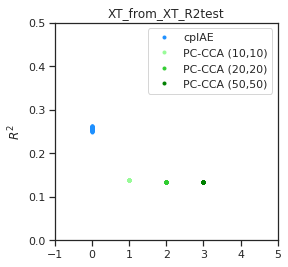

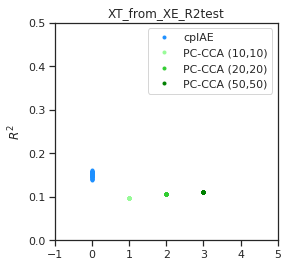

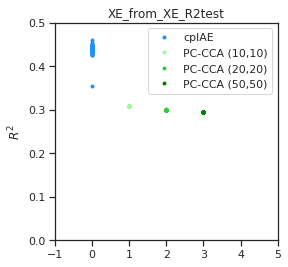

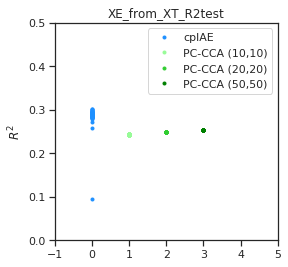

In [70]:
for key in ['XT_from_XT_R2','XT_from_XE_R2','XE_from_XE_R2','XE_from_XT_R2']:
    plt.figure(figsize=(4,4))
    key = key+'test'
    plt.plot(0*np.ones(A[key].values.shape),A[key].values,'.',color='dodgerblue',label='cplAE')
    plt.plot(1*np.ones(B[key].values.shape),B[key].values,'.',color='palegreen',label='PC-CCA (10,10)')
    plt.plot(2*np.ones(C[key].values.shape),C[key].values,'.',color='limegreen',label='PC-CCA (20,20)')
    plt.plot(3*np.ones(C[key].values.shape),D[key].values,'.',color='green',label='PC-CCA (50,50)')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim(0,0.5)
    ax.set_xlim(-1,5)
    ax.set_xlabel('')
    ax.set_ylabel(r'$R^2$')
    ax.set_title(key)

In [28]:
B[key].values.shape

(44,)

1.977419

**Get raw data and init:**

This informs the number of pre-determined clusters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

**Get n=30 way partitions to compare with unsupervised clustering results**

In [3]:
from analysis_tree_helpers import *

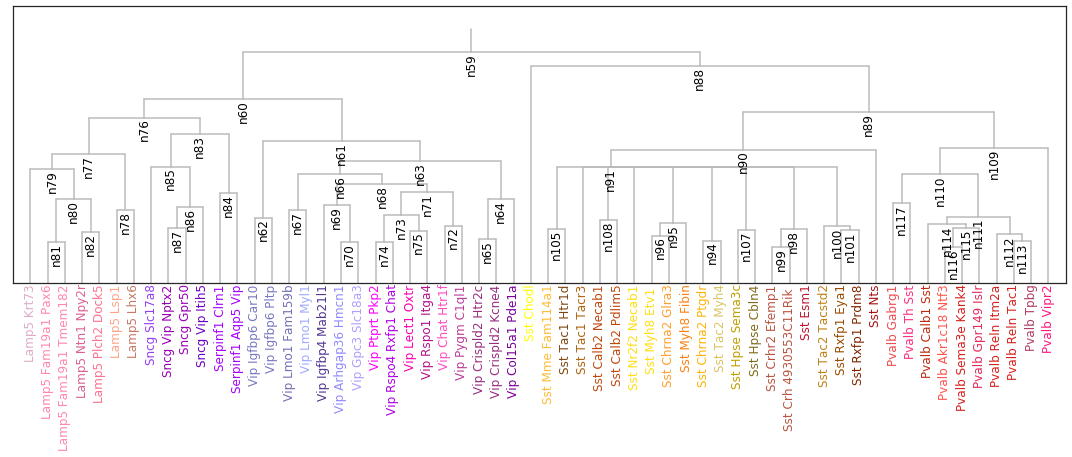

In [4]:
min_samples = 10
n_partitions = 30

#Get inhibitory tree
htree = HTree(htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
subtree = htree.get_subtree(node='n59')
subtree.plot((15,5),fontsize=12)

#Keep nodes that are well-sampled
hist = pd.Series(O['cluster']).value_counts().to_frame().reset_index()
hist.rename(columns = {'index':'celltype',0:'counts'},inplace=True)
well_sampled_types = hist[hist['counts']>=min_samples]
kept_classes = well_sampled_types['celltype'].values.tolist()



---- Plot: New leaf subset: ----


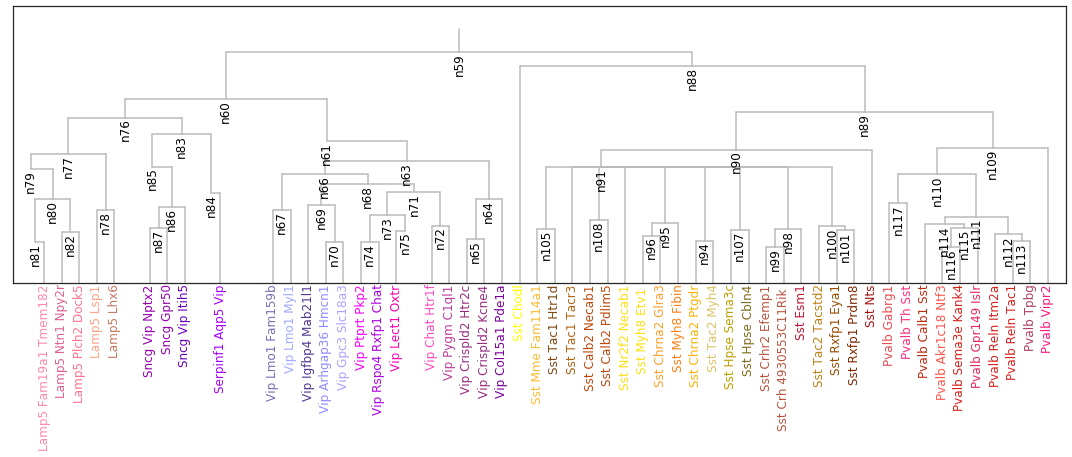



---- Plot: Plot simplified tree: ----
Remove n84 and link ['n83'] to ['Serpinf1 Aqp5 Vip']
Remove n79 and link ['n77'] to ['n80']
Remove n61 and link ['n60'] to ['n63']
Remove n85 and link ['n83'] to ['n86']
Remove n81 and link ['n80'] to ['Lamp5 Fam19a1 Tmem182']
Remove n75 and link ['n73'] to ['Vip Lect1 Oxtr']


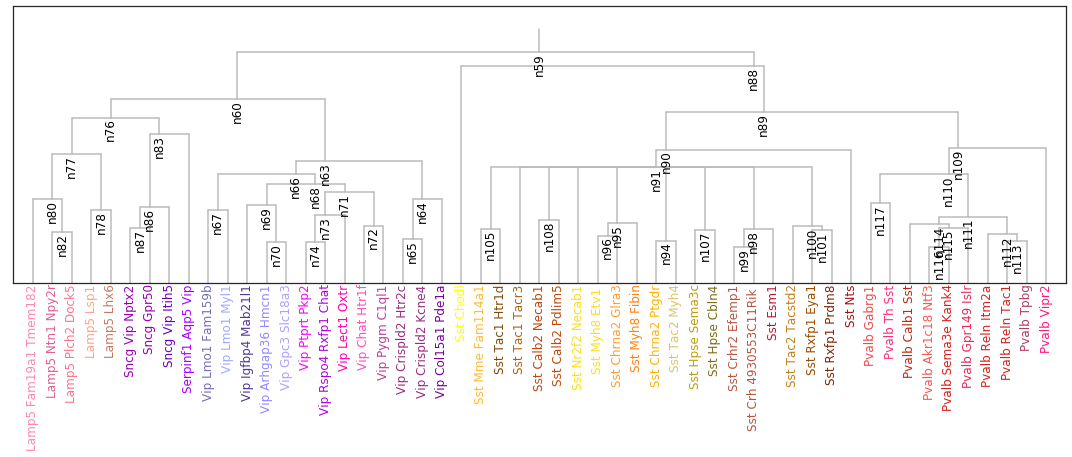

In [5]:
#Obtain all relevant ancestor nodes:
kept_tree_nodes=[]
for node in kept_classes:
    kept_tree_nodes.extend(subtree.get_ancestors(node))
    kept_tree_nodes.extend([node])

kept_subtree_df = subtree.obj2df()
kept_subtree_df = kept_subtree_df[kept_subtree_df['child'].isin(kept_tree_nodes)]

#Plot tree with kept_classes:
print('\n\n---- Plot: New leaf subset: ----')
kept_subtree = HTree(htree_df=kept_subtree_df)
kept_subtree.plot((15,5),fontsize=12)
plt.show()

print('\n\n---- Plot: Plot simplified tree: ----')
mod_subtree,_ = simplify_tree(kept_subtree,skip_nodes=None)
mod_subtree.update_layout()
mod_subtree.plot((15,5),fontsize=12)
plt.show()

In [6]:
start_node_name_list = {}
start_node_name_list['n88'] = mod_subtree.child[mod_subtree.parent=='n91'].tolist() + ['Sst Chodl','Sst Nts'] + \
                              ['n117'] + mod_subtree.child[mod_subtree.parent=='n111'].tolist() + ['Pvalb Vipr2']
print(len(start_node_name_list['n88']))

15


In [7]:
start_node_name_list['n60'] = mod_subtree.child[mod_subtree.parent=='n76'].tolist() + \
                              ['n67','n69','n73','n72','n64']  
print(len(start_node_name_list['n60']))

7


In [8]:
htree = mod_subtree

In [9]:
with timebudget('Calculate valid classifications'):
    valid_classifications = {}
    for n in ['n60','n88']:
        print('Subtree with root node: {:s}'.format(n))
        subtree = htree.get_subtree(node=n)
        start_node_list = [Node(name=nn,C_list=subtree.child,P_list=subtree.parent) for nn in start_node_name_list[n]]
        valid_classifications[n]=[]
        valid_classifications[n] = get_valid_classifications(start_node_list,
                                                          C_list=subtree.child,
                                                          P_list=subtree.parent,
                                                          valid_classes=valid_classifications[n])

    for n in ['n60','n88']:
        valid_classifications[n].sort(key=len)
        hist_counts = pd.Series([len(classification) for classification in valid_classifications[n]]).value_counts().to_frame()
        hist_counts.reset_index(inplace=True)
        hist_counts = hist_counts.rename(columns={'index':'n_classes',0:'classifications'}).sort_values(by='n_classes').reset_index(drop=True)

        print(hist_counts.to_string())
        print('Total: {:d} \n'.format(len(valid_classifications[n])))

Subtree with root node: n60
Subtree with root node: n88
    n_classes  classifications
0           7                1
1           8                7
2           9               27
3          10               74
4          11              158
5          12              275
6          13              399
7          14              488
8          15              505
9          16              441
10         17              322
11         18              193
12         19               92
13         20               33
14         21                8
15         22                1
Total: 3024 

    n_classes  classifications
0          15                1
1          16               10
2          17               50
3          18              166
4          19              409
5          20              792
6          21             1246
7          22             1624
8          23             1772
9          24             1624
10         25             1246
11         26              792


In [10]:
from tqdm import tqdm

In [11]:
classifications = []
for i in tqdm(valid_classifications['n60']):
    for j in valid_classifications['n88']:
        if len(i)+len(j)==n_partitions:
            classifications.append(i+j)    
print(len(classifications))

100%|██████████| 3024/3024 [00:06<00:00, 463.17it/s]

240997


In [12]:
#Store all partitions to file
import json
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
json_file = json.dumps(classifications)
with open(classifications_path+classifications_fname,"w") as f:
    f.write(json_file)

In [13]:
#Read partitions from file
import json
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)

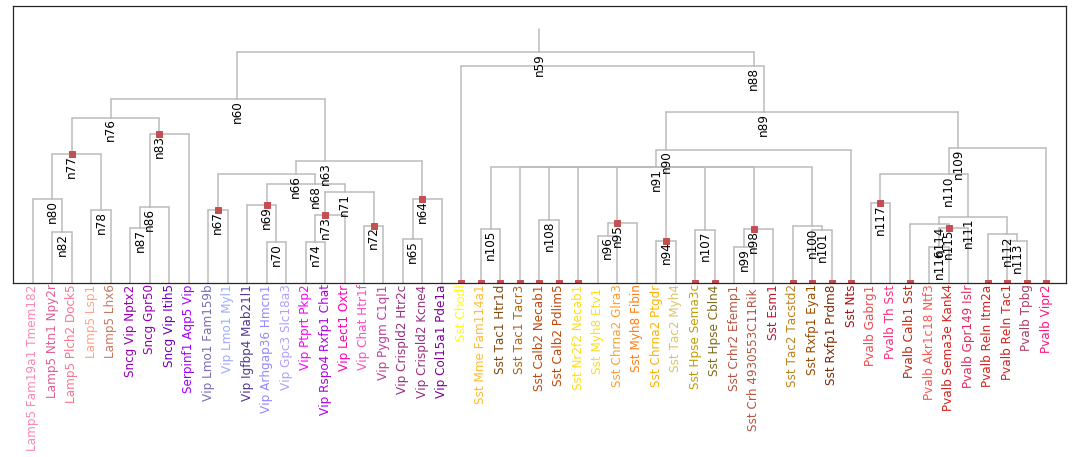

In [19]:
mod_subtree.plot((15,5),fontsize=12)
mod_subtree.plotnodes(classifications[0])
plt.show()

In [14]:
mod_subtree_df = mod_subtree.obj2df()

In [16]:
tree_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
tree_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_well-sampled_inh_tree.json'
mod_subtree_df.to_csv(tree_path+tree_fname)

**Load saved tree and classifications to evaluate**

In [1]:
#Read partitions from file
from copy import deepcopy
import pandas as pd
import json
from analysis_tree_helpers import *

classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)
    
tree_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
tree_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_well-sampled_inh_tree.json'
tree_df = pd.read_csv(tree_path+tree_fname)
htree = HTree(htree_df=tree_df)

**Compare partitions with GMM labels**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
import pickle 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/'

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

with timebudget('fit gmm'):
    best_n_components = 30
    for cv in CVdict.keys():

        fname = 'gmmfit_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_cv_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}.pkl'.format(alpha_T,
                                                                                                       alpha_E,
                                                                                                       lambda_TE,
                                                                                                       cv,
                                                                                                       best_n_components)
        with open(gmm_pth+fname, 'rb') as fid:
            gmm = pickle.load(fid)

        #Label predictions using GMM fits:
        CVdict[cv]['ccT_lbl'] = gmm.predict(CVdict[cv]['zT'])
        CVdict[cv]['ccE_lbl'] = gmm.predict(CVdict[cv]['zE'])
        #bic[cv] = gmm.bic(CVdict[cv]['zT'])
        
        

load all cv sets took 10.287sec
fit gmm took 854.98ms


In [20]:
len(CVdict)

44

In [49]:
ari_mat = np.zeros((len(CVdict),len(CVdict)))
for i in range(len(CVdict)):
    for j in range(len(CVdict)):
        ari_mat[i,j] = ari(CVdict[i]['ccT_lbl'],CVdict[j]['ccT_lbl'])

In [42]:
from scipy.optimize import linear_sum_assignment
# np.fill_diagonal(ari_mat, 0.5)
# row_ind,col_ind = linear_sum_assignment(-ari_mat)

# ari_mat_ordered = ari_mat.copy()
# ari_mat_ordered = ari_mat_ordered[:,col_ind]
#ari_mat_ordered = ari_mat_ordered[row_ind,:]

In [54]:
ind = np.argsort(df['mseTT'].values)

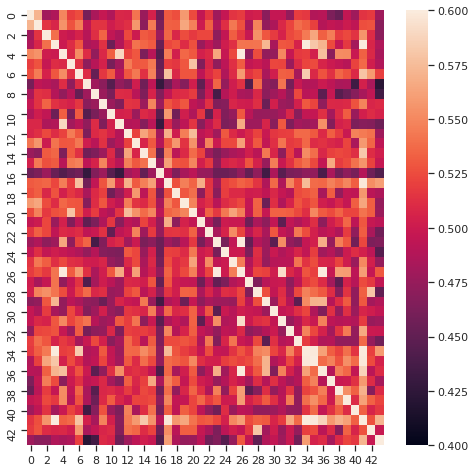

In [56]:
plt.figure(figsize=(8,8))
ari_mat = ari_mat[:,ind]
ari_mat = ari_mat[ind,:]
sns.heatmap(ari_mat,annot=False,vmin=0.4,vmax=0.6)
plt.show()

In [ ]:
        
#Calculate ARI after merging based on mod_subtree

from tqdm import tqdm

with timebudget('Indexing classification'):
    print(len(classifications))

ari_vals = np.empty((len(classifications),1))
with timebudget('relabeling with ari'):
    for i in tqdm(range(len(classifications),1)):
        new_labels = relabel_ordered_classes_nonhierarchical(data_labels=O['cluster'],
                                                            ref_labels=classifications[i],
                                                            ref_htree=htree)
        x[i] = ari(new_labels,CVdict[cv]['ccT_lbl'])

def relabel_ordered_classes_nonhierarchical(data_labels,ref_labels,ref_htree):
    """
    `data_labels` numpy array is updated based on `ref_labels` as per hierarchy in `ref_htree`.
    `data_labels` not appearing ref_labels or any child node of ref_labels are left unchanged.

    returns:
    new_data_labels
    new_data_label_order
    """
    new_data_labels = data_labels.copy()
    for label in ref_labels:
        labels_to_merge = htree.get_descendants(label,leafonly=True)
        new_data_labels[np.isin(new_data_labels,labels_to_merge)]=label

    return new_data_labels

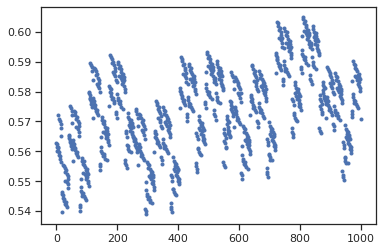

In [35]:
plt.plot(x,'.')

In [38]:
O['cluster']

array(['Vip Gpc3 Slc18a3', 'Sst Calb2 Pdlim5', 'Sst Hpse Cbln4', ...,
       'Lamp5 Fam19a1 Pax6', 'Sncg Vip Nptx2', 'Sncg Vip Itih5'],
      dtype=object)

In [44]:
kept_cells = np.isin(O['cluster'],htree.child[htree.isleaf])

**Compare ARI, BIC and MSE**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
import pickle 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import accuracy_score


sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['XrE','XrT','zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        CVdict[cv]['mse_T_per_cell'] = np.mean((CVdict[cv]['XrT'] - XT_orig)**2,axis=1)
        CVdict[cv]['mse_E_per_cell'] = np.nanmean((CVdict[cv]['XrE'] - XE_orig)**2,axis=1)
        CVdict[cv]['mse_TE_per_cell'] = np.nanmean((CVdict[cv]['zE'] - CVdict[cv]['zT'])**2,axis=1)

        keep_T = CVdict[cv]['mse_T_per_cell']<np.percentile(CVdict[cv]['mse_T_per_cell'],90)
        keep_E = CVdict[cv]['mse_E_per_cell']<np.percentile(CVdict[cv]['mse_E_per_cell'],90)
        keep_TE = CVdict[cv]['mse_TE_per_cell']<np.percentile(CVdict[cv]['mse_TE_per_cell'],90)
        #print('Number of kept cells : {}'.format(np.sum(np.logical_and(keep_T,keep_E))))
        #print('Cells poorly reconstructed in both : {}'.format(np.sum(np.logical_and(~keep_T,~keep_E))))
        CVdict[cv]['keep_T'] = keep_T
        CVdict[cv]['keep_E'] = keep_E
        CVdict[cv]['keep_TE'] = keep_TE
        del X

load all cv sets took 10.889sec


In [3]:
mse_T = []
mse_E = []
mse_TE = []
for i in range(len(CVdict)):
    #keep = np.logical_and(CVdict[i]['keep_T'],CVdict[i]['keep_E'])
    keep = CVdict[i]['keep_TE']
    mse_T.append(np.mean(CVdict[i]['mse_T_per_cell'][keep]))
    mse_E.append(np.mean(CVdict[i]['mse_E_per_cell'][keep]))
    mse_TE.append(np.mean(CVdict[i]['mse_TE_per_cell'][keep]))

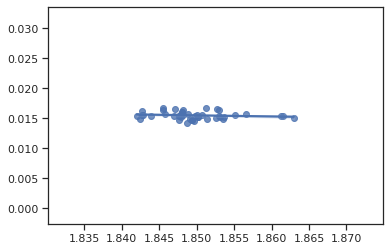

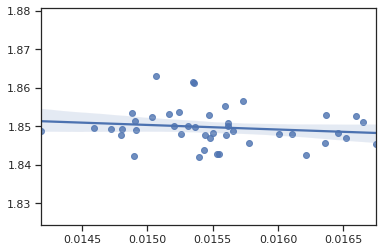

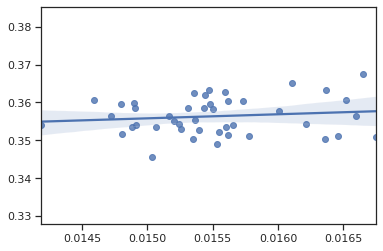

In [6]:
plt.figure()
sns.regplot(mse_T,mse_TE)
plt.show()

plt.figure()
sns.regplot(mse_TE,mse_T)
ax = plt.gca()
ax.set_xlim(np.min(mse_TE),np.max(mse_TE))
plt.show()

plt.figure()
sns.regplot(mse_TE,mse_E)
ax = plt.gca()
ax.set_xlim(np.min(mse_TE),np.max(mse_TE))
plt.show()

In [7]:
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/'

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 44


with timebudget('fit gmm'):
    best_n_components = 30
    for cv in CVdict.keys():

        fname = 'gmmfit_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_cv_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}.pkl'.format(alpha_T,
                                                                                                       alpha_E,
                                                                                                       lambda_TE,
                                                                                                       cv,
                                                                                                       best_n_components)
        with open(gmm_pth+fname, 'rb') as fid:
            gmm = pickle.load(fid)

        #Label predictions using GMM fits:
        CVdict[cv]['ccT_lbl'] = gmm.predict(CVdict[cv]['zT'])
        CVdict[cv]['ccE_lbl'] = gmm.predict(CVdict[cv]['zE'])

fit gmm took 1.809sec


In [10]:
ari_mat = np.zeros((len(CVdict),len(CVdict)))
sort_mat = np.zeros((len(CVdict),len(CVdict)))
for i in range(len(CVdict)):
    for j in range(len(CVdict)):
        keep_i = np.logical_and(CVdict[i]['keep_T'],CVdict[i]['keep_E'])
        keep_j = np.logical_and(CVdict[i]['keep_T'],CVdict[i]['keep_E'])
        ari_mat[i,j] = ari(CVdict[i]['ccT_lbl'][keep_i],
                           CVdict[j]['ccT_lbl'][keep_j])
        
        sort_mat[i,j] = np.mean(CVdict[i]['mse_T_per_cell'][keep_i]) + \
                        np.mean(CVdict[j]['mse_T_per_cell'][keep_j])
        

Text(0, 0.5, 'sum of T mse')

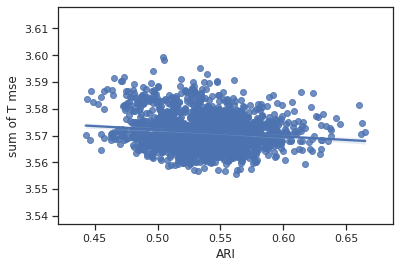

In [14]:
sns.regplot(np.ravel(ari_mat[ari_mat<1]),np.ravel(sort_mat[ari_mat<1]),'.')
ax = plt.gca()
ax.set_xlabel('ARI')
ax.set_ylabel('sum of T mse')

In [43]:
sort_val = []
for i in range(len(CVdict)):
    sort_val.append()
sort_val = np.array(sort_val)    

In [47]:
ind = np.argsort(sort_val)

In [48]:
ari_mat_sorted = ari_mat.copy()
ari_mat_sorted = ari_mat_sorted[ind,:]
ari_mat_sorted = ari_mat_sorted[:,ind]

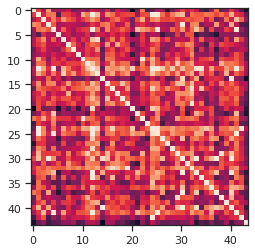

In [50]:
plt.imshow(ari_mat_sorted,vmax=0.6)

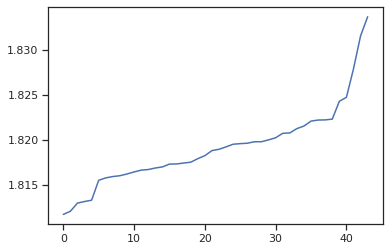

In [54]:
plt.plot(sort_val[ind])

In [52]:
np.sort(ari_mat_sorted[ari_mat_sorted<1])

array([0.43319244, 0.43732964, 0.43736475, ..., 0.64350466, 0.65350345,
       0.65470898])

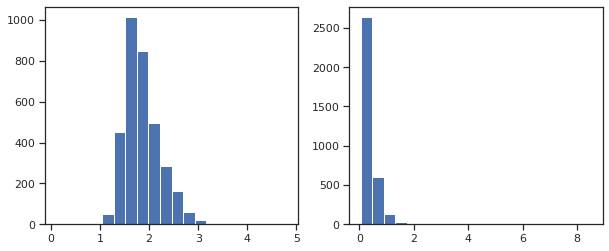

In [36]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(CVdict[cv]['mse_T_per_cell'],bins=20)

plt.subplot(1,2,2)
plt.hist(CVdict[cv]['mse_E_per_cell'],bins=20)  
plt.gca()

In [15]:
import pandas as pd
import json

In [ ]:
ari_df = []
for cv in range(44):
    ari_df.append(pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/ari_ref_partitions_cv_{}v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0.csv'.format(cv)))

best_ari_val = []
for df in ari_df:
    best_ari_val.append(df['ARI'].max())
best_ari_val = np.array(best_ari_val)

In [ ]:
bic_vals = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/gmmfits_combined_aT_1_0_aE_1_0_cs_1_0_ld_3_ne_1500_fiton_zT.csv')
bic_vals = bic_vals.loc[bic_vals.n_components==30]
bic_vals = bic_vals.sort_values(by='cv').reset_index(drop=True)
bic_vals = bic_vals['bic_train'].values

In [ ]:
mse_vals_T_from_T = []
for cv in range(44):
    mse_vals_T_from_T.append(CVdict[cv]['ae']['XT_from_XT_test'])
mse_vals_T_from_T = np.array(mse_vals_T_from_T)

In [7]:
#df = pd.DataFrame({'mseTT':mse_vals_T_from_T,'best_ari':best_ari_val,'bic':bic_vals})
df = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/mse-bic-ari.csv')

In [9]:
df.columns

Index(['Unnamed: 0', 'mseTT', 'best_ari', 'bic'], dtype='object')

Text(0, 0.5, 'BIC')

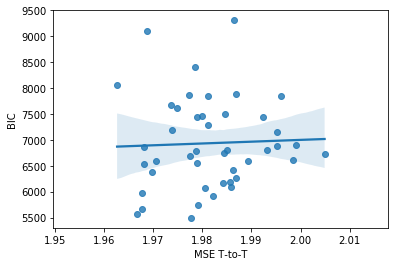

In [10]:
sns.regplot(df['mseTT'].values,df['bic'].values,'.')
ax = plt.gca()
ax.set_xlabel('MSE T-to-T')
ax.set_ylabel('BIC')

Text(0, 0.5, 'BIC')

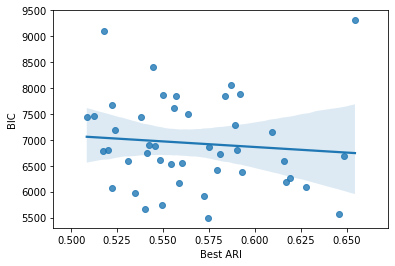

In [12]:
sns.regplot(df['best_ari'].values,df['bic'].values,'.')
ax = plt.gca()
ax.set_xlabel('Best ARI')
ax.set_ylabel('BIC')

Text(0, 0.5, 'MSE T-to-T')

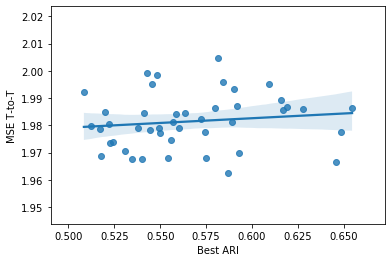

In [13]:
sns.regplot(df['best_ari'].values,df['mseTT'].values,'.')
ax = plt.gca()
ax.set_xlabel('Best ARI')
ax.set_ylabel('MSE T-to-T')

In [16]:
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)

In [17]:
len(classifications)

240997

In [ ]:
ind = []
best = np.array(classifications[ind[-1]])
for i in range(-2,-100,-1):
    best = np.array(best[np.isin(best,classifications[ind[i]])])